In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('feature_selection_top_states.csv', index_col = 'Date', parse_dates = True)
df.head()

,contact_tracing,debt_relief,restrictions_on_internal_movement,current_intensive_care_patients,facial_coverings,public_information_campaigns,testing_policy,income_support,public_transport_closing,new_cases_50_min,...,NATIVE_PEOPLES,booster_rate,vaccination_policy,maximum_temperature_celsius,prop_age85plus,prop_age6064,prop_age8084,vaccination_rate_1dose,PEOPLE_POSITIVE_NEW_CASES_COUNT,PROVINCE_STATE_NAME
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-01,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2020-03-02,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,5,California
2020-03-03,1.0,1.0,0.5,112.5,0.5,1.5,2.0,0.0,0.0,5.0,...,873999,0.0,2.5,26.848765,1.860398,5.818187,1.71647,0.0,7,California
2020-03-04,1.0,1.0,0.0,112.5,0.0,1.0,1.0,0.0,0.0,5.0,...,873999,0.0,0.0,24.685185,1.860398,5.818187,1.71647,0.0,10,California
2020-03-05,1.0,1.0,0.0,112.5,0.0,1.0,1.0,1.0,0.0,5.0,...,873999,0.0,0.0,25.753086,1.860398,5.818187,1.71647,0.0,12,California


In [3]:
df.shape

(7900, 52)

In [4]:
ca_df = df[df['PROVINCE_STATE_NAME'] == 'California']
ca_df.shape

(790, 52)

In [5]:
ca_df.drop(columns = ['PROVINCE_STATE_NAME'], inplace = True)
ca_df.shape

(790, 51)

In [6]:
#separate train & test sets
train_size = int(len(ca_df)* 0.85)
ca_train, ca_test = ca_df[0:train_size], ca_df[train_size:]

In [7]:
#identify best features among 179 using PCA -- to help speed up 
X_ca_train = ca_train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
X_ca_test = ca_test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT']) 
y_ca_train = ca_train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
y_ca_test = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

EARLY STOPPING XGBOOST MODEL

In [8]:
reg = xgb.XGBRegressor(learning_rate=0.3,n_estimators=1000, early_stopping_rounds=10)
reg.fit(X_ca_train, y_ca_train,
        eval_set=[(X_ca_train, y_ca_train), (X_ca_test, y_ca_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

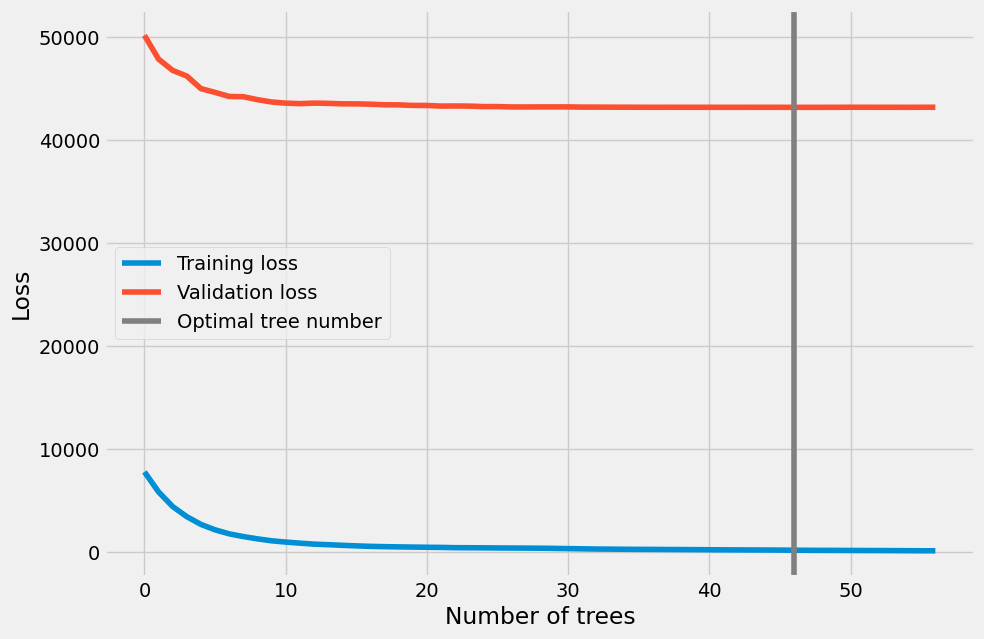

In [10]:
results = reg.evals_result()

plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(reg.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

In [11]:
reg.best_iteration

46

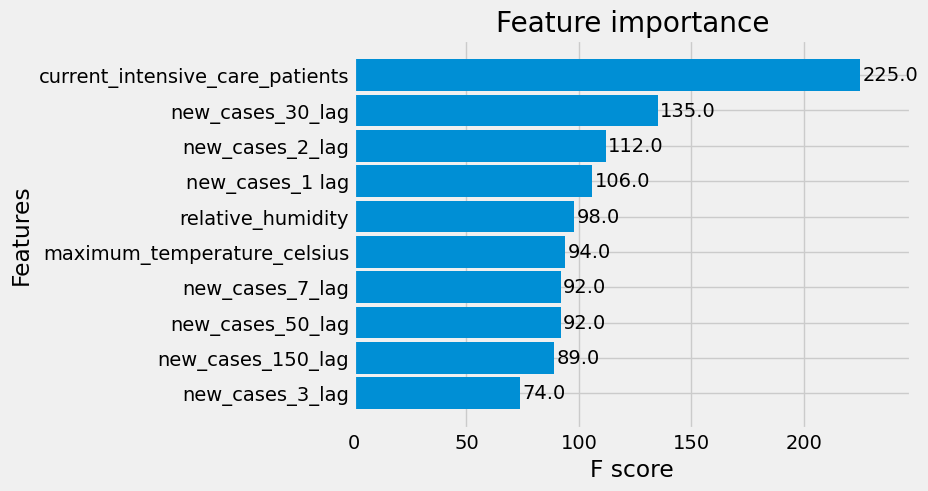

In [12]:
_ = plot_importance(reg, height=0.9 ,max_num_features = 10)

In [13]:
ca_test['MW_Prediction'] = reg.predict(X_ca_test)
full_set = pd.concat([ca_test, ca_train], sort=False)

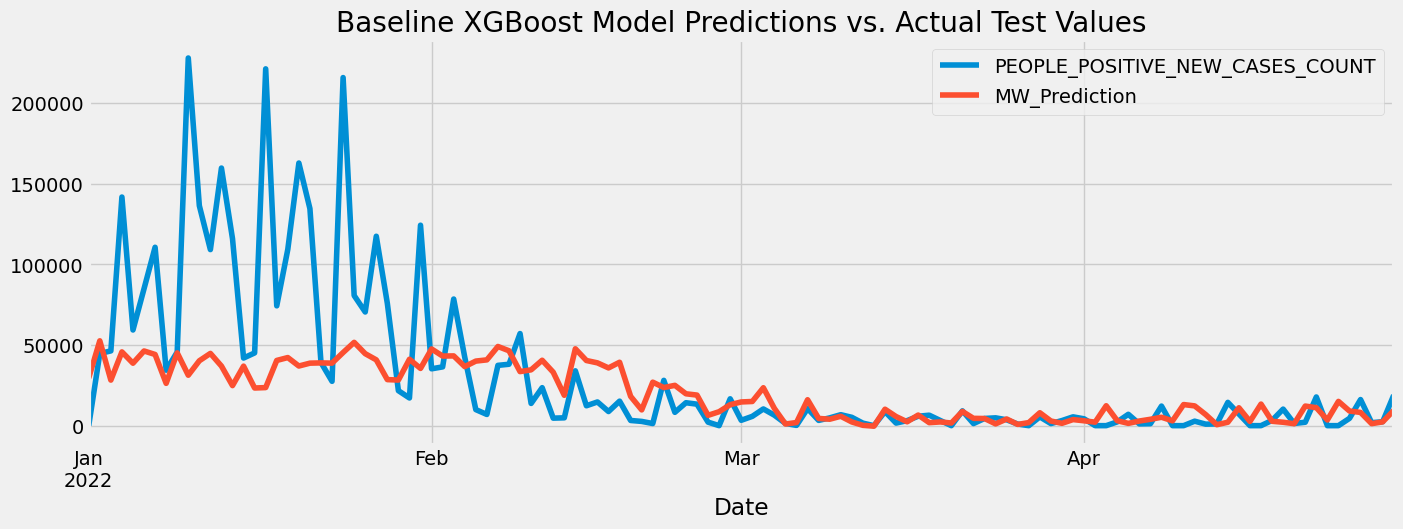

In [14]:
#visualize actual test data vs the model's predictions
_ = ca_test[['PEOPLE_POSITIVE_NEW_CASES_COUNT','MW_Prediction']].plot(figsize=(15, 5), title = 'Baseline XGBoost Model Predictions vs. Actual Test Values')

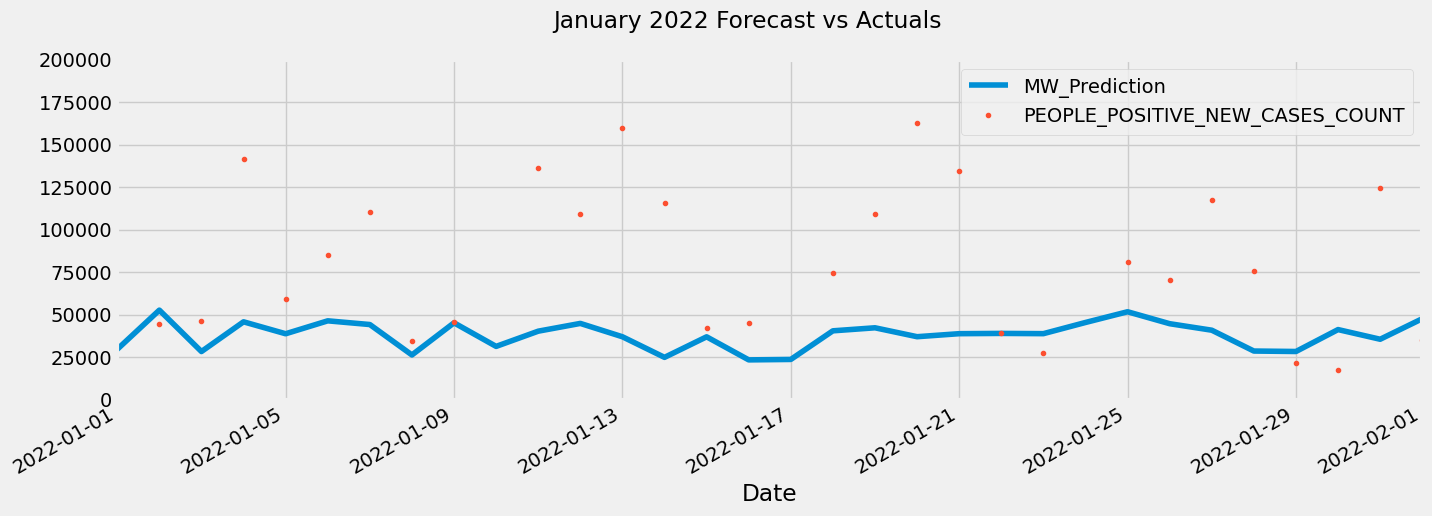

In [18]:
# look at just the first month of predictions
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='02-01-2022')
ax.set_ylim(0, 200000)
plot = plt.suptitle('January 2022 Forecast vs Actuals')

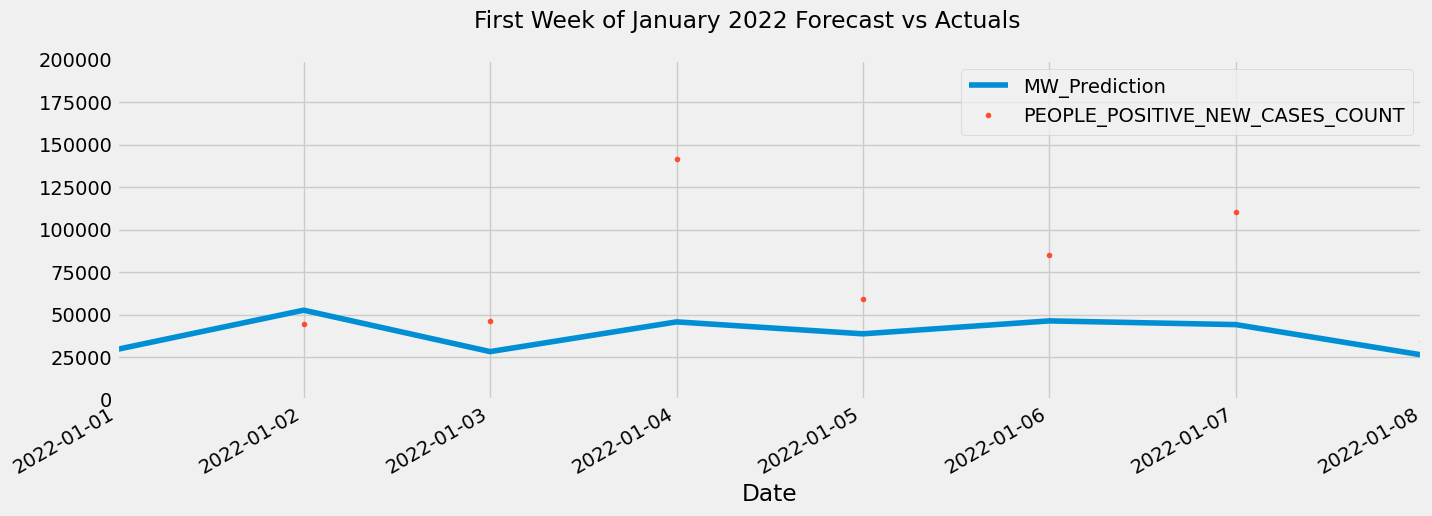

In [19]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='01-01-2022', upper='01-08-2022')
ax.set_ylim(0, 200000)
plot = plt.suptitle('First Week of January 2022 Forecast vs Actuals')

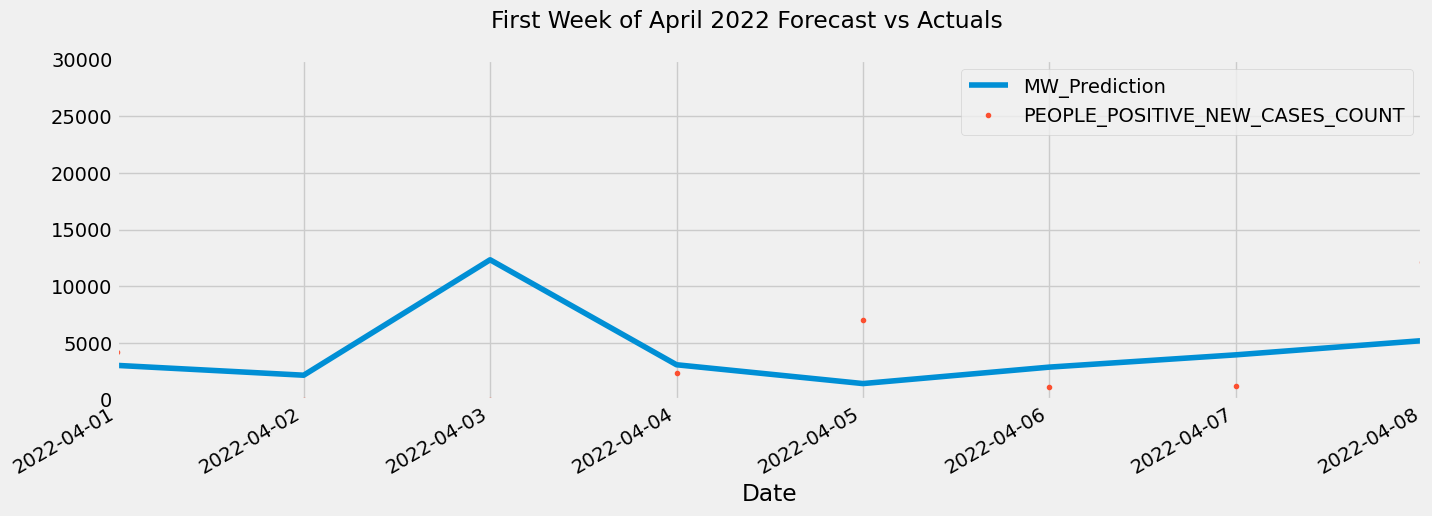

In [20]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = full_set[['MW_Prediction','PEOPLE_POSITIVE_NEW_CASES_COUNT']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 30000)
ax.set_xbound(lower='04-01-2022', upper='04-08-2022')
plot = plt.suptitle('First Week of April 2022 Forecast vs Actuals')

In [22]:
model_rmse = mean_squared_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction'], squared=False)
model_mae = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction'])

print('Baseline Model Test MAE: ', model_mae)
print('Baseline Model Test RMSE: ', model_rmse)
#naive forecast for mase calculation
naive_forecast = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = model_mae / mae_naive
print('Baseline Model Test MASE: ', mase)

Baseline Model Test MAE:  21808.96935778706
Baseline Model Test RMSE:  43216.49678782529
Baseline Model Test MASE:  0.9324178633712634


HYPERPARAMETER TUNING


In [33]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import ParameterGrid


param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'subsample': [0.5, 0.7, 1.0]
}
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)
best_score = np.inf
best_params = None
for params in ParameterGrid(param_grid):
    scores = []

    for train_idx, test_idx in tscv.split(ca_df):
        train = ca_df.iloc[train_idx]
        test = ca_df.iloc[test_idx]

       #drop the target column
        X_train = train.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
        y_train = train['PEOPLE_POSITIVE_NEW_CASES_COUNT']
    
        X_test = test.drop(columns=['PEOPLE_POSITIVE_NEW_CASES_COUNT'])
        y_test = test['PEOPLE_POSITIVE_NEW_CASES_COUNT']

        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train)

        #make predictions on the test data
        forecast = model.predict(X_test)
    
        score = mean_squared_error(y_test, forecast)
        scores.append(score)

    avg_score = np.mean(scores)
    if avg_score < best_score:
        best_score = avg_score
        best_params = params

print(f"Best Parameters: {best_params}")

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 500, 'subsample': 1.0}


In [34]:
tuned_reg = xgb.XGBRegressor(colsample_bytree = 1.0, learning_rate=0.3, max_depth = 3, n_estimators=500, subsample = 1.0, early_stopping_rounds=10)
tuned_reg.fit(X_ca_train, y_ca_train,
        eval_set=[(X_ca_train, y_ca_train), (X_ca_test, y_ca_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=10,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

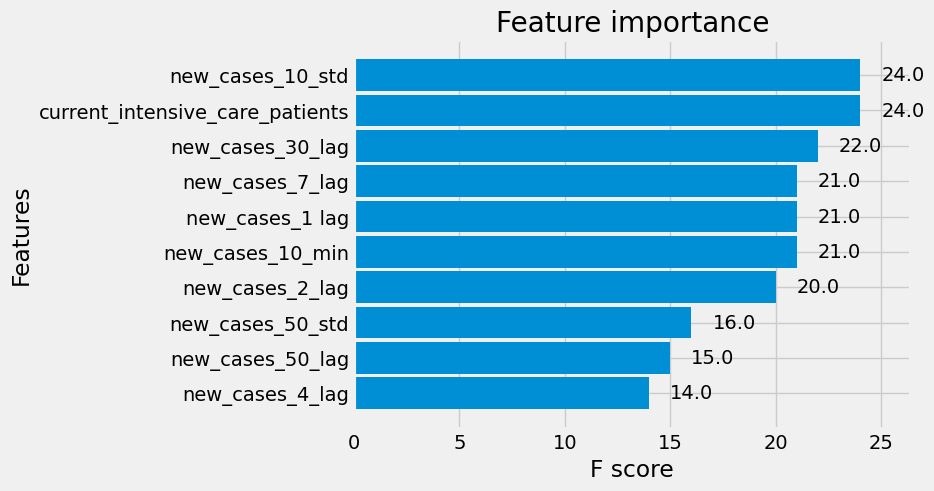

In [35]:
_ = plot_importance(tuned_reg, height=0.9 ,max_num_features = 10)

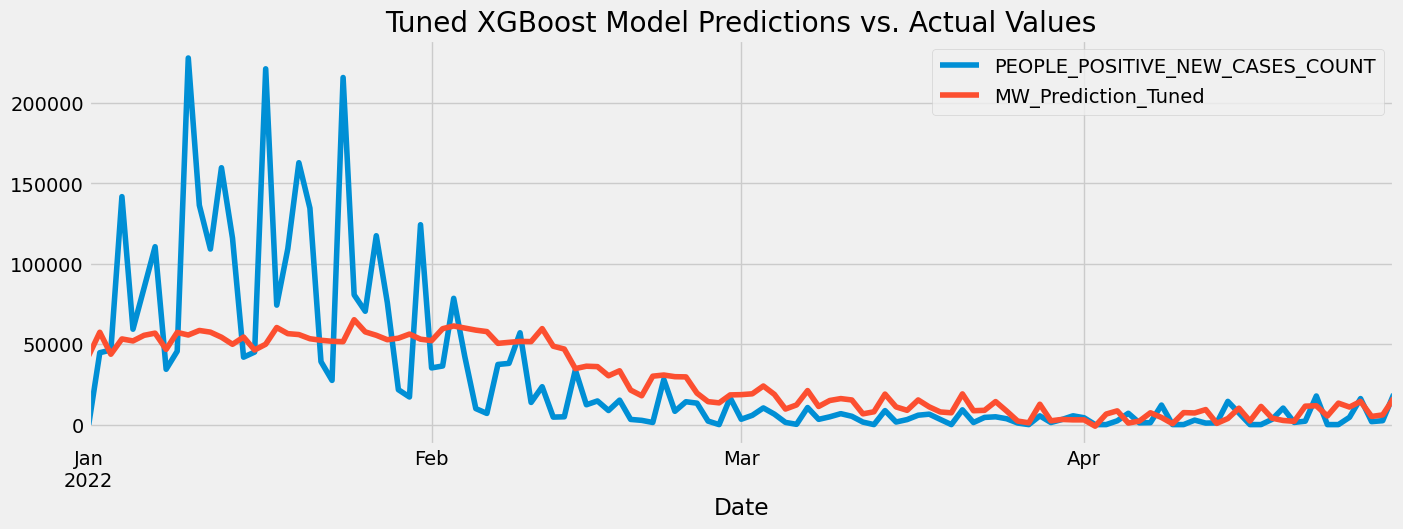

In [36]:
ca_test['MW_Prediction_Tuned'] = tuned_reg.predict(X_ca_test)
_ = ca_test[['PEOPLE_POSITIVE_NEW_CASES_COUNT','MW_Prediction_Tuned']].plot(figsize=(15, 5), title = 'Tuned XGBoost Model Predictions vs. Actual Values')

In [38]:
model_rmse = mean_squared_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction_Tuned'], squared=False)
model_mae = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'], ca_test['MW_Prediction_Tuned'])

print('Tuned Model Test MAE: ', model_mae)
print('Tuned Model Test RMSE: ', model_rmse)
#naive forecast for mase calculation
naive_forecast = ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'].shift(1)
#mae of the naive forecast (excluding first NaN value)
mae_naive = mean_absolute_error(ca_test['PEOPLE_POSITIVE_NEW_CASES_COUNT'][1:], naive_forecast.dropna())
mase = model_mae / mae_naive
print('Tuned Model Test MASE: ', mase)

Tuned Model Test MAE:  21860.95099954044
Tuned Model Test RMSE:  38819.53312111779
Tuned Model Test MASE:  0.9346402797790756
